In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, cohen_kappa_score, precision_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import math
from joblib import dump, load
import random
import pickle
import scipy.stats
from PIL import Image
import scipy.stats as stats

from Functions import post_processing
from Functions import general_functions

from skimage.restoration import denoise_bilateral

### Loads all zones with their features and labels

In [2]:
file_list = [f"../../../features/zone_{i}.pickle" for i in range(11, 22)]
importances = np.zeros(0)
predictions = np.zeros(0)

### Performs 11 sub-experiments
Trains with 10 zones for each sub-experiment, and evaluates on one zone.
Each zone is evaluated once. Similar to cross validation but without randomly assigned subsets of data.
All of these 11 zones were hold-out data, which means that they had never before been used in our code.

In [ ]:
i = 11
for (training_files, test_file) in general_functions.yield_training_test_zones(file_list):
    training_dataset = general_functions.create_balanced_dataset(training_files)
    
    X_train = training_dataset.loc[:, training_dataset.columns != "label_3m"]
    y_train = training_dataset["label_3m"]
    training_dataset = None
    
    clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", max_features=25, n_jobs=-1)
    clf.fit(X_train,y_train)
    dump(clf, f"classifier_for_zone_{i}.joblib")
    i += 1
    
    test_dataset = pd.read_pickle(test_file)
    X_test = test_dataset.loc[:, test_dataset.columns != "label_3m"]
    y_test = test_dataset["label_3m"]
    
    proba = clf.predict_proba(X_test)[:,1:].reshape(2997,2620)
    
    proba_post_process = post_processing.proba_post_process(proba, 6, 0.4)
    
    labels_grid = post_processing.raster_to_zones(y_test.reshape(2997, 2620), 6, 4)
    np.append(predictions, (proba, proba_post_process.reshape(-1), labels_grid.reshape(-1)))
    
    np.save("predictions.npy", predictions)
    
    importances = clf.feature_importances_
    feature_names = dataset.columns.values.tolist()[1:]
    tuple_features = [(feature_names[i], importance) for i, importance in enumerate(importances)]
    experiment_importances = np.zeros(len(X_test.shape[1]))
    for f in range(X_test.shape[1]):
        np.append(experiment_importances, (tuple_features[f][0], tuple_features[f][1]*100))
    np.append(importances, experiment_importances)
    np.save("feature_importances_21_experiments.npy", importances)

### Loads saved experiment results from file

In [272]:
predictions = np.load("../Slutexperiment/predictions.npy")
prediction2d = np.concatenate(predictions, axis= 1)
y_pred_all = prediction2d[1]
y_test_all = prediction2d[2]

In [273]:
predictions.shape

(11, 3, 7852140)

In [274]:
predictions = predictions.reshape(11, 3, 2997, 2620)

In [275]:
predictions.shape

(11, 3, 2997, 2620)

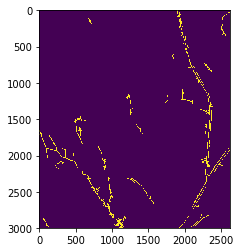

In [276]:
# 0 proba, 1 binary pred, 2 labels
plt.imshow(predictions[0, 1])

In [ ]:
for i in range(predictions.shape[0]):
    pred = predictions[i, 1]
    #new_pred = pred.copy()
    labels = predictions[i, 2]
    new_labels = labels.copy()
    false_positives = np.zeros(pred.shape)
    false_negatives = np.zeros(pred.shape)
    for j in range(pred.shape[0]):
        for k in range(pred.shape[1]):
            if pred[j, k] == 1 and labels[j, k] == 0:
                false_positives[j, k] = 1
            elif pred[j, k] == 0 and labels[j, k] == 1:
                false_negatives[j, k] = 1
    for j in range(0, len(pred) - 6, 6):
        for k in range(0, len(pred[i]) - 6, 6):
            if false_positives[j, k] == 1:
                if labels[j+6, k] == 1 or labels[j-6, k] == 1 or labels[j, k+6] == 1 or labels[j, k-6] == 1:
                    for l in range(j, j+6):
                        for m in range(k, k+6):
                            new_labels[l, m] = 1
            if false_negatives[j, k] == 1:
                if pred[j+6, k] == 1 or pred[j-6, k] == 1 or pred[j, k+6] == 1 or pred[j, k-6] == 1:
                    for l in range(j, j+6):
                        for m in range(k, k+6):
                            new_labels[l, m] = 0
                            
    np.save(f"../Slutexperiment/new_labels_zone_{i+1}.npy", new_labels)

In [392]:
for i in range(0, len(new_labels)):
    for j in range(0, len(new_labels[i])):
        if new_labels[i, j] != 0 and new_labels[i, j] != 1:
            print("it's fucked")

In [393]:
np.unique(labels)

array([ 0.,  1.])

In [394]:
np.unique(new_labels)

array([ 0.,  1.])

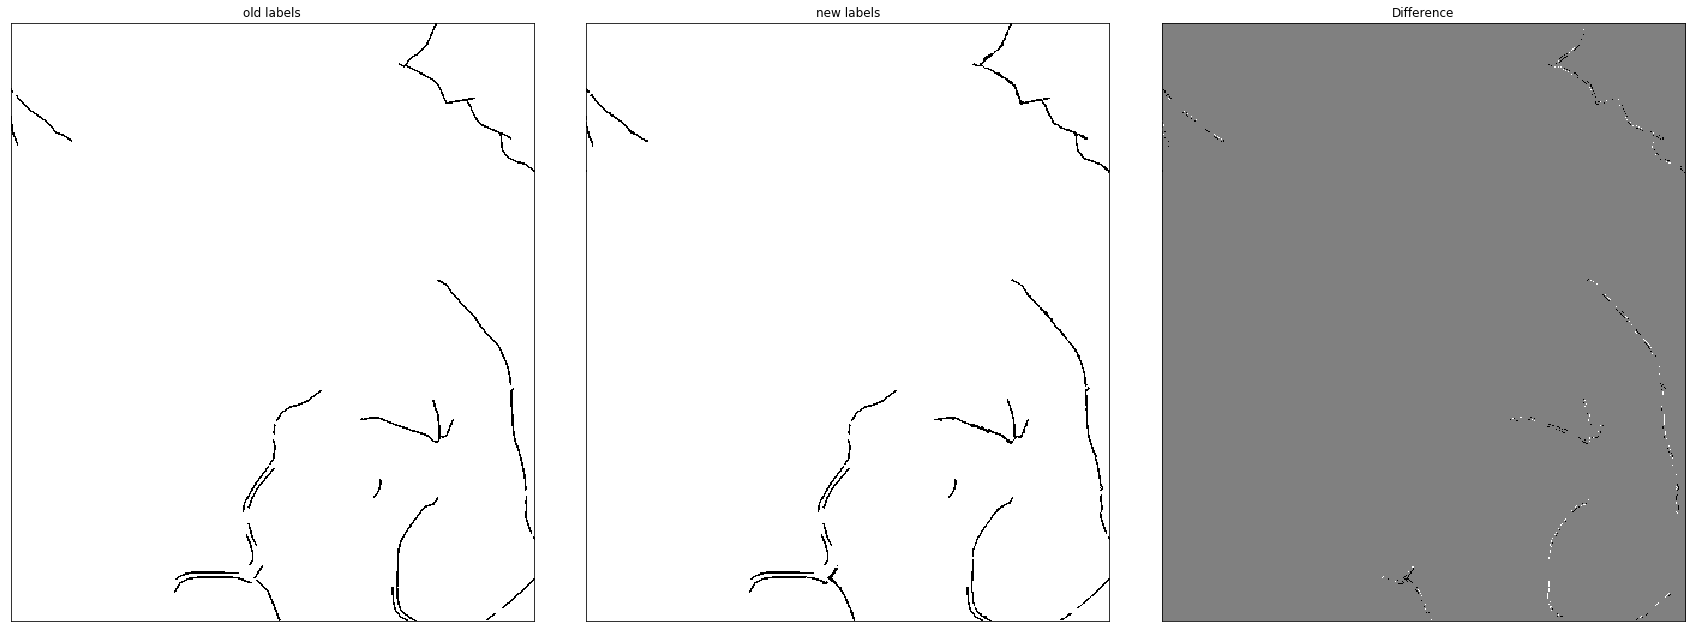

In [395]:
plt.figure(num=None, figsize=(30,90), facecolor='w', edgecolor='k')
ax = [plt.subplot(1,3,i+1) for i in range(3)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0.1,hspace=0.1)

ax[0].title.set_text(f"old labels")
ax[0].imshow(labels * -1, cmap = "gray")
ax[1].title.set_text(f"new labels")
ax[1].imshow(new_labels * -1, cmap = "gray")
ax[2].title.set_text(f"Difference")
ax[2].imshow((new_labels - labels)  * -1, cmap = "gray")

In [396]:
np.count_nonzero(pred)

68256

In [397]:
np.count_nonzero(labels)

70492

In [398]:
np.count_nonzero(new_labels)

73876

In [399]:
new_labels.shape

(2997, 2620)

In [400]:
labels.shape

(2997, 2620)

In [401]:
pred.shape

(2997, 2620)

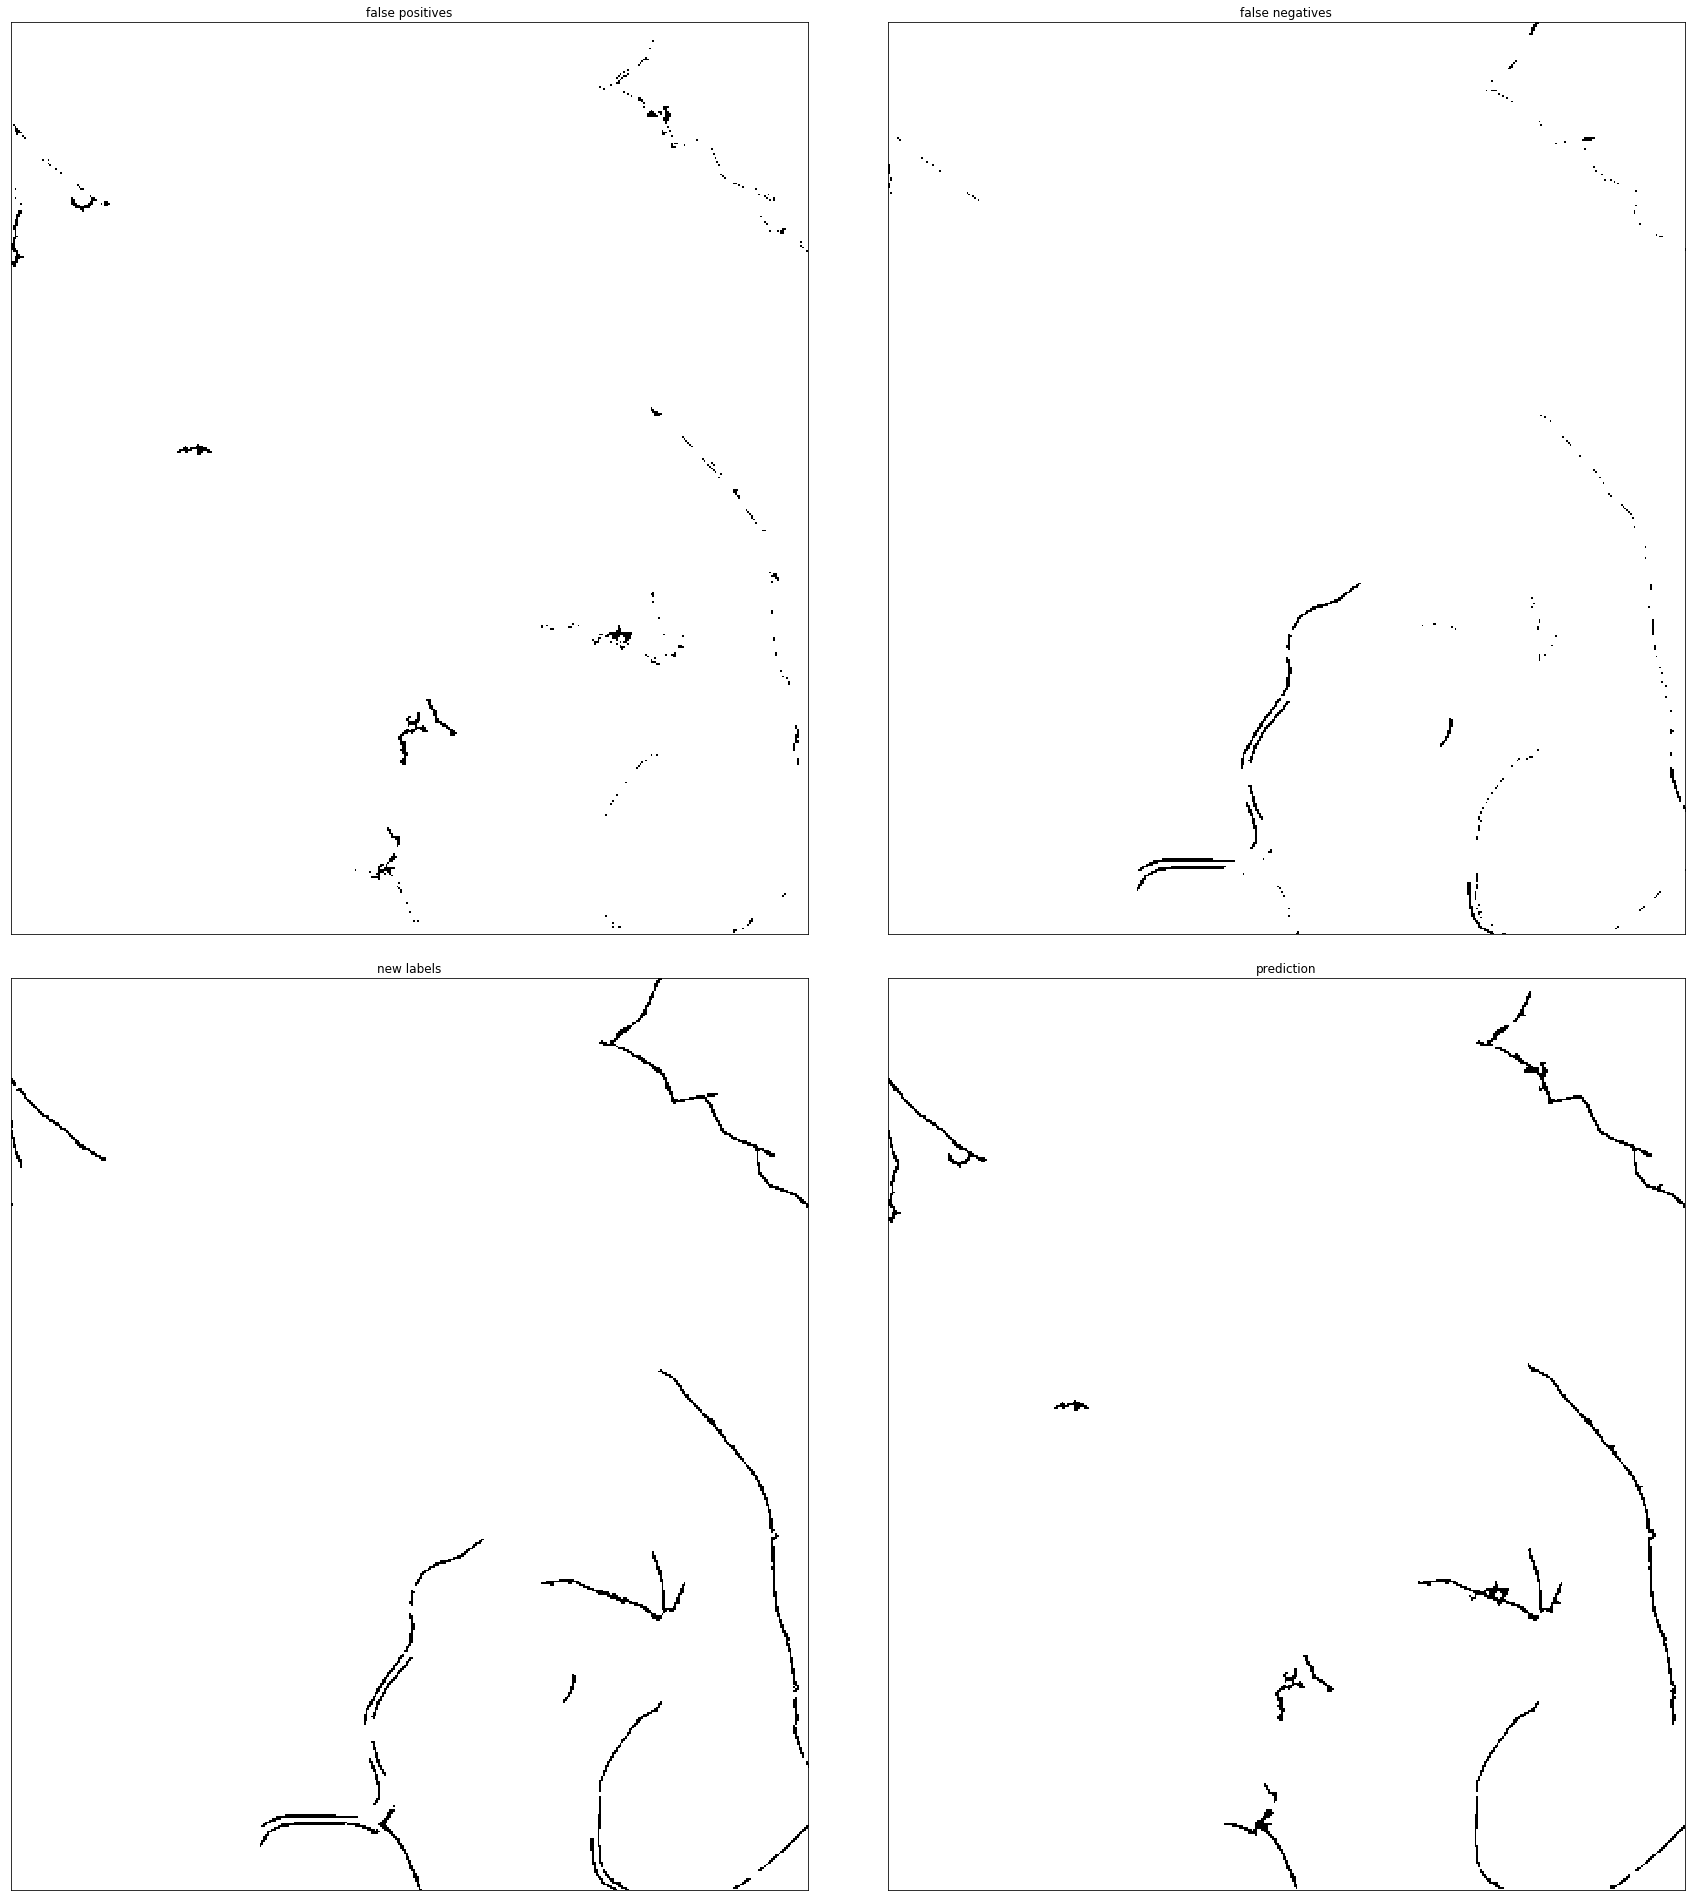

In [405]:
plt.figure(num=None, figsize=(30,35), facecolor='w', edgecolor='k')
ax = [plt.subplot(2,2,i+1) for i in range(4)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0.1,hspace=0.01)

ax[0].title.set_text(f"false positives")
ax[0].imshow(false_positives * -1, cmap = "gray")
ax[1].title.set_text(f"false negatives")
ax[1].imshow(false_negatives * -1, cmap = "gray")
ax[2].title.set_text(f"new labels")
ax[2].imshow(new_labels * -1, cmap = "gray")
ax[3].title.set_text(f"prediction")
ax[3].imshow(pred * -1, cmap = "gray")

In [385]:
pred = pred.reshape(-1)
labels = labels.reshape(-1)
print("Accuracy score             ", accuracy_score(labels, pred))
print("Recall score               ", recall_score(labels, pred))
print("Precision score            ", precision_score(labels, pred))
precision, recall, threshholds = precision_recall_curve(labels,pred)
auc_score = auc(recall, precision)
print("Cohen's kappa score        ", cohen_kappa_score(labels, pred))
print("AUPRC score                ", auc_score)

Accuracy score              0.99268224968
Recall score                0.576576065369
Precision score             0.595464135021
Cohen's kappa score         0.582177382033
AUPRC score                 0.587920728559


In [386]:
new_labels = new_labels.reshape(-1)
print("Accuracy score             ", accuracy_score(new_labels, pred))
print("Recall score               ", recall_score(new_labels, pred))
print("Precision score            ", precision_score(new_labels, pred))
precision, recall, threshholds = precision_recall_curve(new_labels,pred)
auc_score = auc(recall, precision)
print("Cohen's kappa score        ", cohen_kappa_score(new_labels, pred))
print("AUPRC score                ", auc_score)

Accuracy score              0.994864584686
Recall score                0.689046510369
Precision score             0.745780590717
Cohen's kappa score         0.713704826798
AUPRC score                 0.718876336484


### Metrics for the entirety of the data used in the experiment

In [10]:
print("Accuracy score             ", accuracy_score(y_test_all, y_pred_all))
print("Recall score               ", recall_score(y_test_all, y_pred_all))
print("Precision score            ", precision_score(y_test_all, y_pred_all))
precision, recall, threshholds = precision_recall_curve(y_test_all,y_pred_all)
auc_score = auc(recall, precision)
print("Cohen's kappa score        ", cohen_kappa_score(y_test_all, y_pred_all))
print("AUPRC score                ", auc_score)
print("Confusion matrix\n", confusion_matrix(y_test_all, y_pred_all))

Accuracy score              0.984320487501
Recall score                0.654722221103
Precision score             0.601061906484
Cohen's kappa score         0.618752578307
AUPRC score                 0.631363190483
Confusion matrix
 [[83882221   754668]
 [  599627  1137024]]


### Calculates metrics for each of the 11 zones used in the experiment.

In [4]:
metrics_per_zone = []
for i, zone in enumerate(predictions):
    proba, binary_prediction, labels_grid = zone
    acc = accuracy_score(labels_grid, binary_prediction)
    _recall = recall_score(labels_grid, binary_prediction)
    _precision = precision_score(labels_grid, binary_prediction)
    kappa = cohen_kappa_score(labels_grid, binary_prediction)
    precision, recall, threshholds = precision_recall_curve(labels_grid, binary_prediction)
    auc_score = auc(recall, precision)
    metrics = (acc, _recall, _precision, kappa, auc_score)
    metrics_per_zone.append(metrics)
    print(f"Zone {i+1}:\nAccuracy: {metrics[0]}, Recall: {metrics[1]}, Precision: {metrics[2]}, Cohen's Kappa: {metrics[3]}, AUPRC: {metrics[4]}\n")


Zone 1:
Accuracy: 0.9834102550387538, Recall: 0.5912118201339701, Precision: 0.5810841460648674, Cohen's Kappa: 0.5776403709201021, AUPRC: 0.5902088505826781

Zone 2:
Accuracy: 0.9665343460508855, Recall: 0.6067067763904954, Precision: 0.6674703847363456, Cohen's Kappa: 0.6181432673188108, AUPRC: 0.6465500140070424

Zone 3:
Accuracy: 0.9814845379730875, Recall: 0.5982806915869796, Precision: 0.6125395569620253, Cohen's Kappa: 0.5958474103084976, AUPRC: 0.6101771049956817

Zone 4:
Accuracy: 0.9752085418752086, Recall: 0.7524043752452223, Precision: 0.5238666346845766, Cohen's Kappa: 0.6052867533638304, AUPRC: 0.6414305302701029

Zone 5:
Accuracy: 0.9790371796733119, Recall: 0.7330721657684889, Precision: 0.6540623403168114, Cohen's Kappa: 0.6805037066843651, AUPRC: 0.6978409287539848

Zone 6:
Accuracy: 0.9876261757941147, Recall: 0.3907912791584083, Precision: 0.5080875356803045, Cohen's Kappa: 0.4356377641237199, AUPRC: 0.45325601028176077

Zone 7:
Accuracy: 0.9870277402084018, Recall:

#### Formula for calculating confidence interval.

In [9]:
def mean_confidence_interval(data, confidence = 0.95):
    sample = np.array(data)
    sample_size, sample_mean = len(sample), sample.mean()
    z_critical = stats.norm.ppf(q = ((1+confidence) / 2.))  # Get the z-critical value*
    margin_of_error = z_critical * (sample.std() / math.sqrt(sample_size))
    return (sample_mean, sample_mean - margin_of_error, sample_mean + margin_of_error)

### Calculates confidence intervals for each metric based on the results from the 11 zones.

In [10]:
metric_names = ["accuracy", "recall", "precision", "Cohen's Kappa", "AUPRC"]
avg = 0
for i in range(0, 5):
    for interval in [0.90, 0.95, 0.99]:
        conf_int = mean_confidence_interval([j[i] for j in metrics_per_zone], interval)
        avg = conf_int[0]
        print(f"Confidence interval for {metric_names[i]} at {interval * 100}%: [{conf_int[1]}, {conf_int[2]}]")
    print(f"Average for {metric_names[i]}: {avg}")
    print("\n")

Confidence interval for accuracy at 90.0%: [0.980418804541273, 0.9882221704610252]
Confidence interval for accuracy at 95.0%: [0.9796713455014298, 0.9889696295008684]
Confidence interval for accuracy at 99.0%: [0.978210479208294, 0.9904304957940042]
Average for accuracy: 0.9843204875011491


Confidence interval for recall at 90.0%: [0.5929965883166706, 0.711907846231912]
Confidence interval for recall at 95.0%: [0.5816064656975455, 0.723297968851037]
Confidence interval for recall at 99.0%: [0.5593451171526778, 0.7455593173959048]
Average for recall: 0.6524522172742913


Confidence interval for precision at 90.0%: [0.5653805136484279, 0.6143104859556764]
Confidence interval for precision at 95.0%: [0.5606936707531387, 0.6189973288509656]
Confidence interval for precision at 99.0%: [0.5515335021793709, 0.6281574974247334]
Average for precision: 0.5898454998020521


Confidence interval for Cohen's Kappa at 90.0%: [0.5734804077797702, 0.6388729019289134]
Confidence interval for Cohen's Ka

### Takes the feature importances for the 11 experiments and averages them for an overall feature importance score.

In [12]:
importances = np.load("../Slutexperiment/feature_importances_21_experiments.npy")
names = [i[0] for i in importances[0]]

weights = np.zeros(81, dtype=float)    
for zone_importance in importances:
    imp = np.array([item for item in zone_importance[:,1]], dtype=float)
    for i in range(len(imp)):
        weights[i] += imp[i]
weights/=importances.shape[0]

avg_importances = [(names[i], weights[i]) for i in range(importances.shape[1])] 
avg_importances = sorted(avg_importances, key= lambda x: x[1], reverse=True)

for i, item in enumerate(avg_importances):
    print("{:>2}. {:<35}  {:.2f} %".format(i+1, item[0], item[1]))

 1. impundment_mean_3                    11.08 %
 2. impundment_mean_4                    7.44 %
 3. hpmf_mean_4                          7.03 %
 4. hpmf_mean_3                          3.97 %
 5. impundment_median_4                  2.97 %
 6. impundment_mean_2                    2.53 %
 7. skyview_gabor_no_streams             2.03 %
 8. impundment_amplified                 1.91 %
 9. hpmf_median_4                        1.90 %
10. impoundment_amplified_no_streams     1.76 %
11. slope_std_6                          1.62 %
12. skyview_non_ditch                    1.59 %
13. hpmf_gabor_no_streams                1.59 %
14. skyview_gabor                        1.48 %
15. hpmf_gabor                           1.46 %
16. skyview_max_6                        1.39 %
17. hpmf_mean_6                          1.39 %
18. impundment_std_4                     1.39 %
19. slope_min_6                          1.31 %
20. slope_non_ditch                      1.25 %
21. hpmf_min_4                         

### Raw probability prediction, final binary prediction and labels for each zone

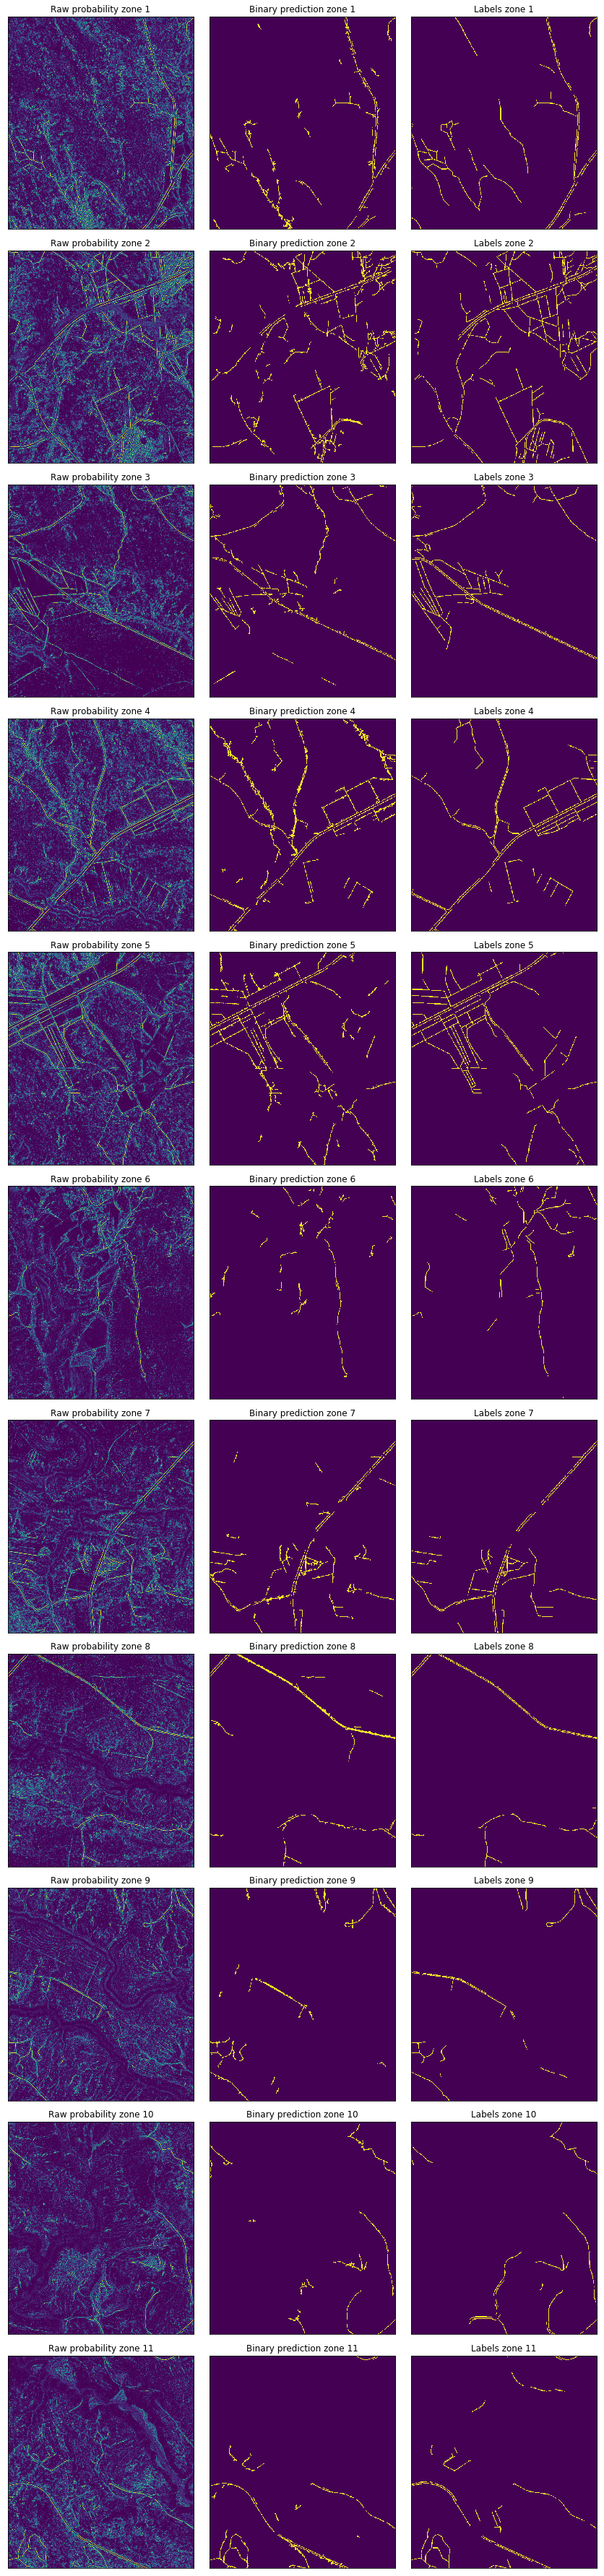

In [11]:
plt.figure(num=None, figsize=(15,65), facecolor='w', edgecolor='k')
ax = [plt.subplot(11,3,i+1) for i in range(33)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for i, zone_pred in enumerate(predictions):
    ax[i*3].title.set_text(f"Raw probability zone {i+1}")
    ax[i*3].imshow(zone_pred[0].reshape(2997,2620))
    ax[i*3+1].title.set_text(f"Binary prediction zone {i+1}")
    ax[i*3+1].imshow(zone_pred[1].reshape(2997,2620))
    ax[i*3+2].title.set_text(f"Labels zone {i+1}")
    ax[i*3+2].imshow(zone_pred[2].reshape(2997,2620))

### Result graphics for each zone
Green indicates a correct ditch prediction.

Red indicates an incorrect ditch prediction.

Blue indicates a missed ditch prediction.

Black indicates a correct non-ditch prediction.

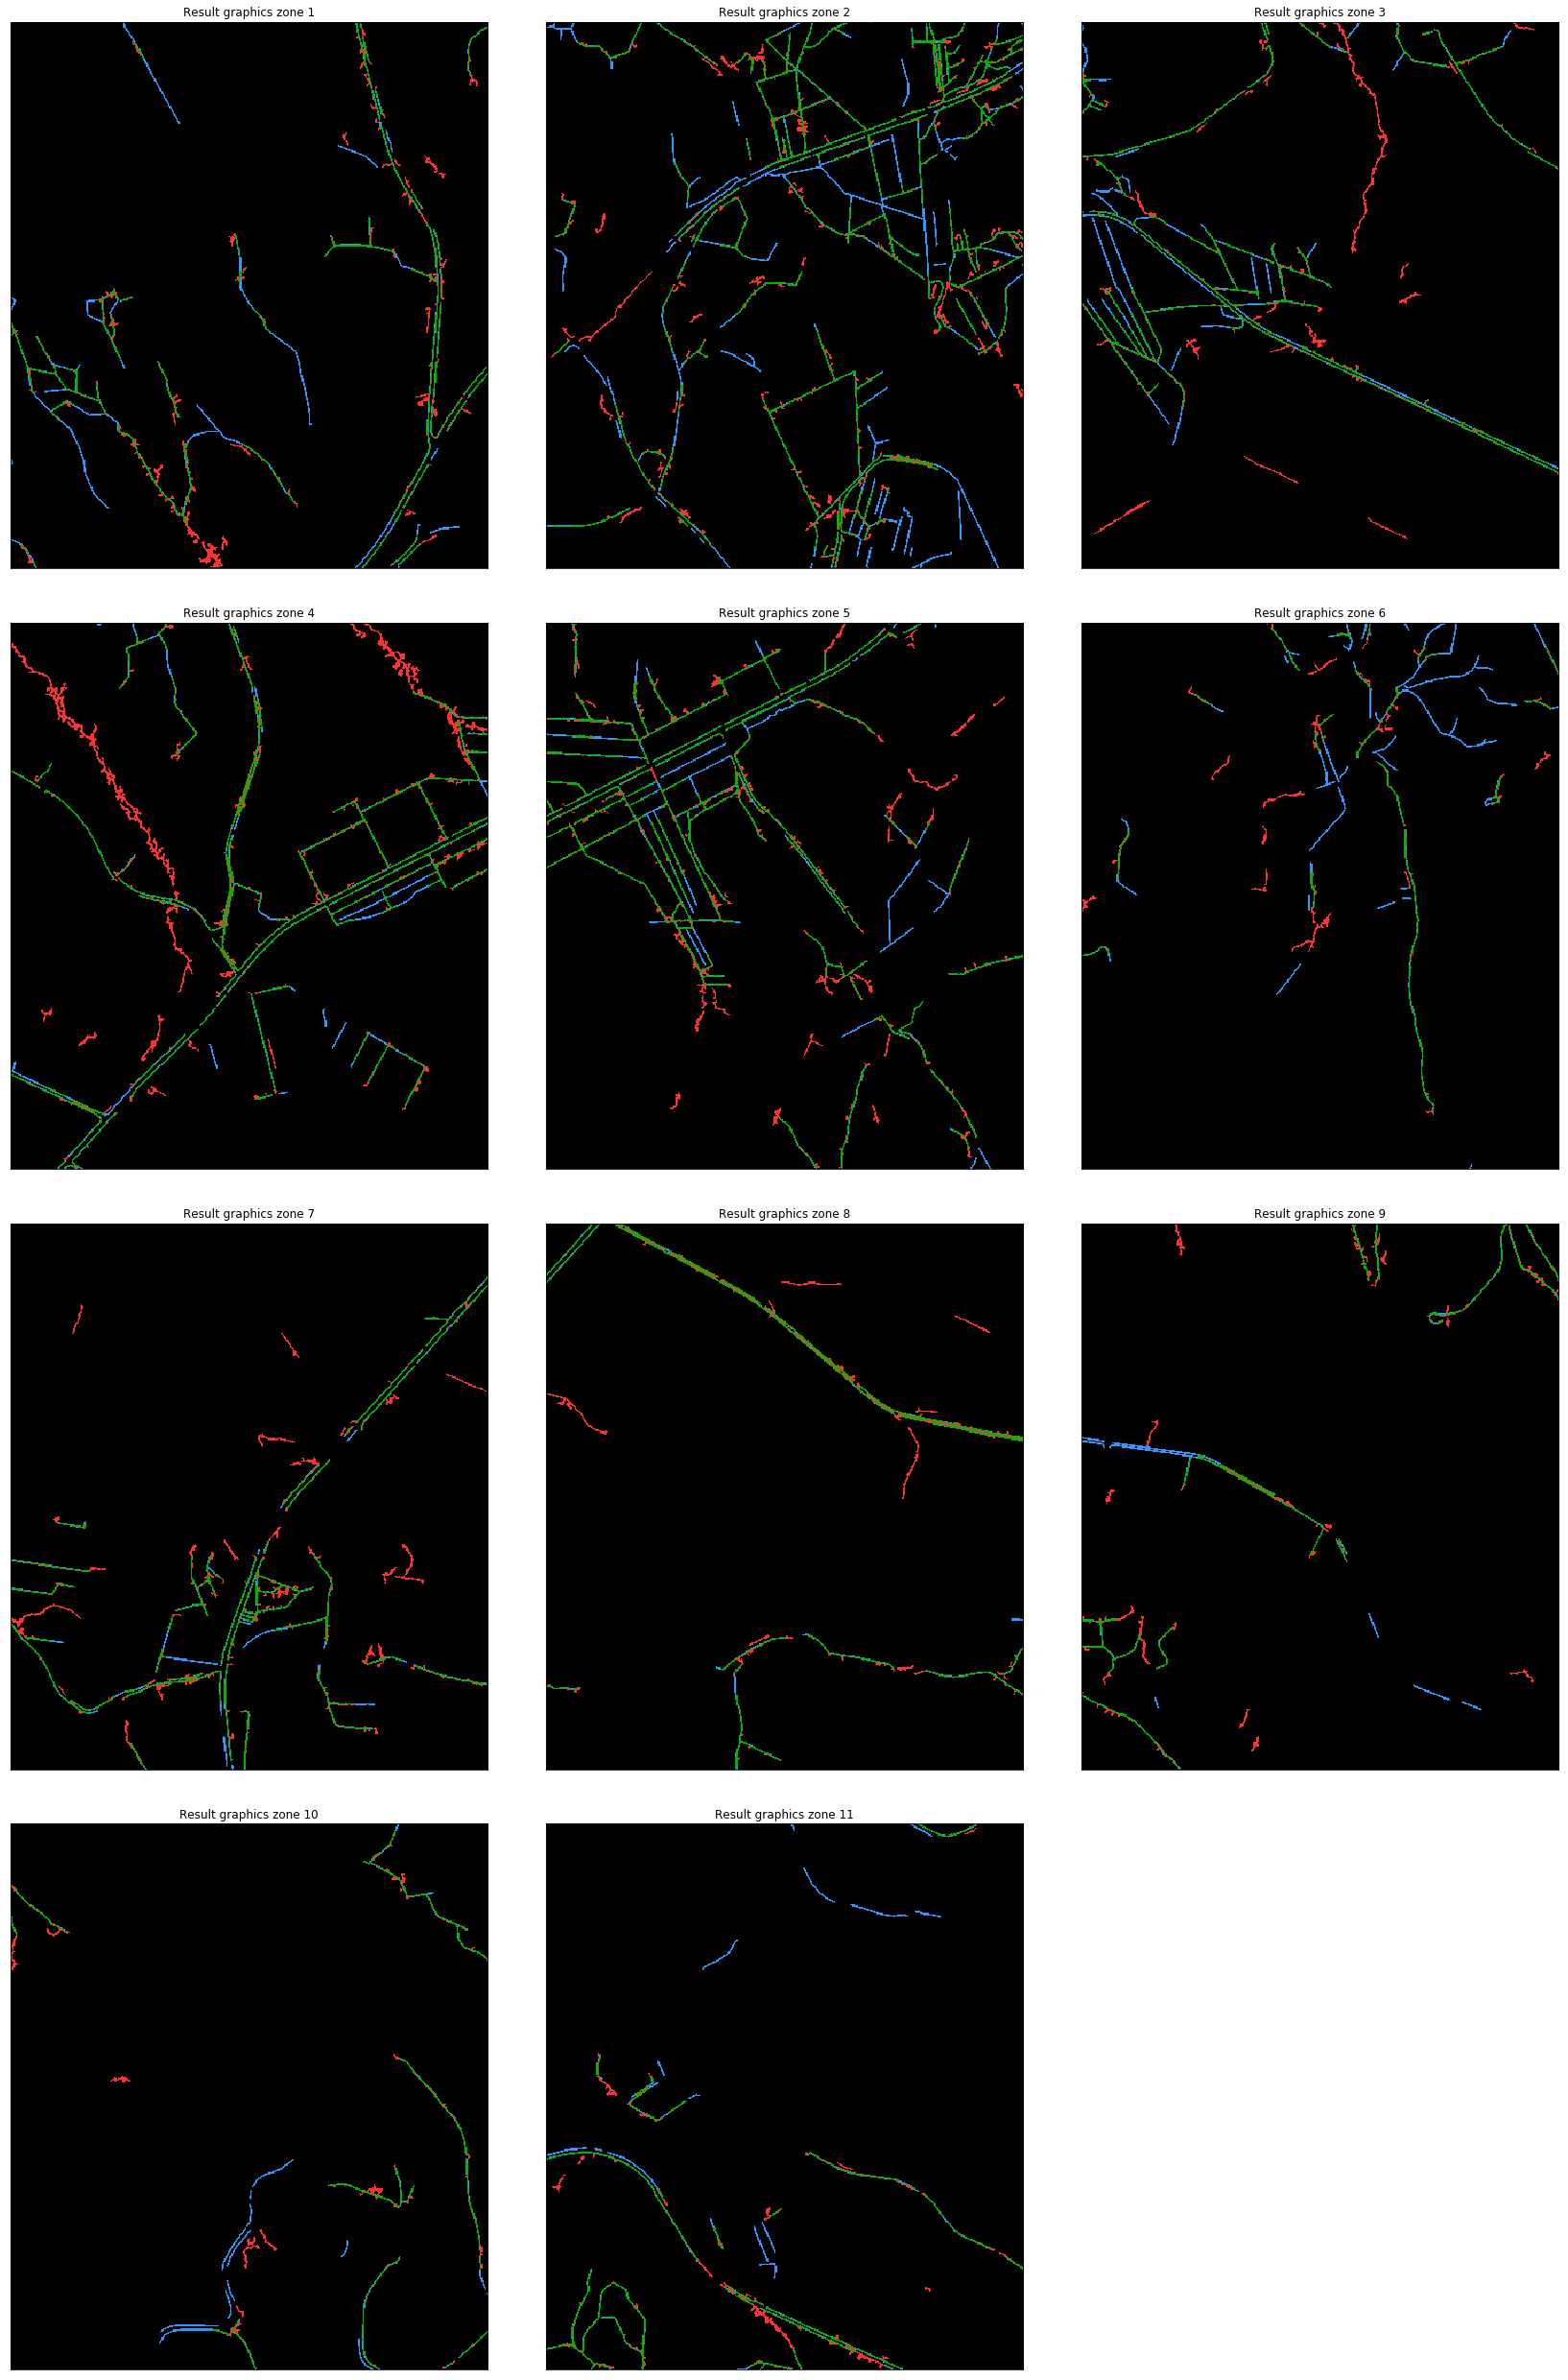

In [12]:
plt.figure(num=None, figsize=(30,45), facecolor='w', edgecolor='k')
ax = [plt.subplot(4,3,i+1) for i in range(11)]
for a in ax:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.tick_params(bottom=False, left=False)
plt.subplots_adjust(wspace=0,hspace=0.1)

for k, zone_pred in enumerate(predictions):
    validation = zone_pred[2].reshape(2997,2620)
    pred = zone_pred[1].reshape(2997,2620)
    displayImg = Image.new("RGB", (2620, 2997), "black")
    pixels = displayImg.load()
    for i in range(displayImg.size[0]):
        for j in range(displayImg.size[1]):
            if validation[j][i] == 1 and pred[j][i] == 1:
                pixels[i,j] = (0, 180, 0)
            elif validation[j][i] == 1 and pred[j][i] == 0:
                pixels[i,j] = (50, 150, 255)
            elif validation[j][i] == 0 and pred[j][i] == 1:
                pixels[i,j] = (255, 50, 50)
    
    ax[k].title.set_text(f"Result graphics zone {k+1}")
    ax[k].imshow(displayImg)